# Example: Find a model for Proteins

In [1]:
import json
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader


import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define color-blind-friendly palette
hex1 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
hex1_inverted = hex1[::-1]
colors1=[mcolors.to_rgb(i) for i in hex1]

## Load protein data from PDB dataset

In [2]:
jsons = []
with gzip.open('../../../supplemental_material/pdb/dataset_6000.gz', 'r') as file:
    for line in file:
        jsons.append(json.loads(line))

In [3]:
data = jsons[0]
print(str(len(data)) + " entries")

5139 entries


In [4]:
def char_to_float(s):
    parts = s.split()
    for i in range(len(parts)):
        if parts[i].isalpha():
            parts[i] = float(ord(parts[i]))/100
        else:
            parts[i] = float(parts[i])
    return np.sum(parts)/len(parts)


## Generate train and test datasets from entries of the proteins

### Problem 1: Learn relation between Solvent Content and Matthews Coefficient

In [5]:
all_inputs = np.zeros((len(data), 1))
all_targets = np.zeros((len(data), 1))
indices = []
for i in range(len(data)):
    entry = data[i]['entry']
    if 'exptl_crystal' in entry and 'density_matthews' in entry['exptl_crystal'][0] and 'density_percent_sol' in entry['exptl_crystal'][0]:
        all_inputs[i] = entry['exptl_crystal'][0]['density_matthews']
        all_targets[i] = entry['exptl_crystal'][0]['density_percent_sol']
        indices.append(i)
    # else:
    #     print('skipped %d' % i)
all_inputs = all_inputs[indices]
all_targets = all_targets[indices]

print('Number of entries: %d' % len(all_inputs))

Number of entries: 5068


#### Set up training and test set

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.random.permutation(len(all_inputs))

# Split the indices for training, testing, and validation sets
train_indices = indices[:5 * len(all_inputs) // 6]
test_indices = indices[5 * len(all_inputs) // 6:]

# Create the training, testing, and validation sets
inputs_training = all_inputs[train_indices]
targets_training = all_targets[train_indices]
inputs_testing = all_inputs[test_indices]
targets_testing = all_targets[test_indices]

#### Normalize inputs

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
inputs_training = scaler.fit_transform(inputs_training)
inputs_testing = scaler.transform(inputs_testing)

In [8]:
input_tensor = torch.tensor(inputs_training, dtype=torch.float32)
target_tensor = torch.tensor(targets_training, dtype=torch.float32)

#### Define model

In [9]:
# Define the model architecture using a sequential container

# define input size, hidden layer size, output size 
D_i, D_k, D_o = 1, 500, 1

# The model consists of:
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o),
)

#### Define Loss Function

In [10]:
# Define the loss function and optimizer
# Mean Squared Error (MSE) is used as the loss function
criterion = nn.MSELoss()

#### Optimization

In [11]:
# Adam optimizer is used with weight decay (L2 regularization) to prevent overfitting
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
# object that decreases learning rate by half every N epochs 
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

#### Training process

In [12]:

# Train the model
num_epochs = 1000  # Number of epochs to train the model
losses = []  # List to store the loss value for each epoch
# load data
data_loader = DataLoader(TensorDataset(input_tensor,target_tensor), batch_size=64)
# Iterate over the epochs
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss value for this epoch
    # Iterate over the training data in batches
    for i, dataset in enumerate(data_loader):
        # Get the inputs and targets from the data loader
        inputs, targets = dataset
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()  
        
        # Forward pass: compute the model output
        outputs = model(inputs)
        # Compute the loss between the model output and the actual targets
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()        # Compute the gradient of the loss with respect to model parameters
        optimizer.step()       # Update the model parameters based on the computed gradients
        
        # Store the loss value for this epoch
        epoch_loss += loss.item()
    losses.append(epoch_loss)  # Store the loss value for this epoch
    print(f'Epoch {epoch:5d}, loss {epoch_loss:.3f}')
    # tell scheduler to consider updating learning rate 
    scheduler.step()

Epoch     0, loss 42974.337
Epoch     1, loss 2000.580
Epoch     2, loss 920.841
Epoch     3, loss 870.782
Epoch     4, loss 854.977
Epoch     5, loss 845.304
Epoch     6, loss 839.103
Epoch     7, loss 835.969
Epoch     8, loss 834.530
Epoch     9, loss 833.847
Epoch    10, loss 833.737
Epoch    11, loss 833.911
Epoch    12, loss 834.336
Epoch    13, loss 834.991
Epoch    14, loss 835.723
Epoch    15, loss 836.626
Epoch    16, loss 837.531
Epoch    17, loss 838.345
Epoch    18, loss 838.982
Epoch    19, loss 839.496
Epoch    20, loss 840.120
Epoch    21, loss 840.078
Epoch    22, loss 840.312
Epoch    23, loss 840.338
Epoch    24, loss 840.110
Epoch    25, loss 839.926
Epoch    26, loss 839.789
Epoch    27, loss 839.671
Epoch    28, loss 839.534
Epoch    29, loss 839.844
Epoch    30, loss 839.853
Epoch    31, loss 840.148
Epoch    32, loss 840.507
Epoch    33, loss 840.872
Epoch    34, loss 841.471
Epoch    35, loss 842.006
Epoch    36, loss 842.578
Epoch    37, loss 843.137
Epoch    

#### Performance

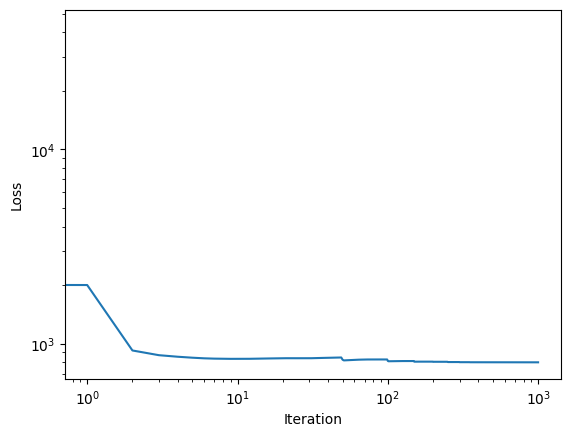

In [13]:
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [14]:
predictions_test = model(torch.tensor(inputs_testing, dtype=torch.float32)).detach().numpy()

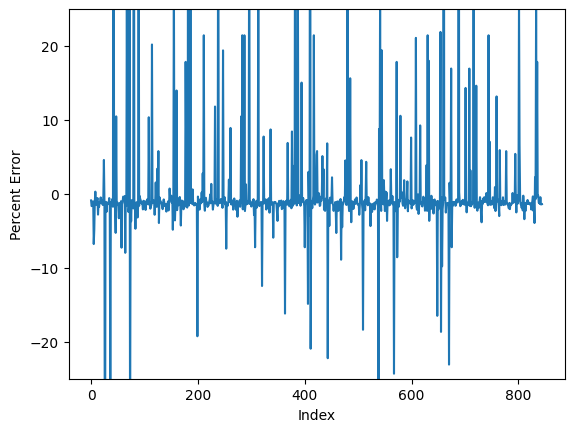

In [15]:
plt.plot(100*(predictions_test/targets_testing-1))
plt.xlabel('Index')
plt.ylabel('Percent Error')
plt.ylim([-25,25])
plt.show()

In [16]:
var_performance = np.sum((predictions_test - targets_testing)**2)/len(predictions_test)
print('Variance of performance: %.3f' % var_performance)

Variance of performance: 13.584


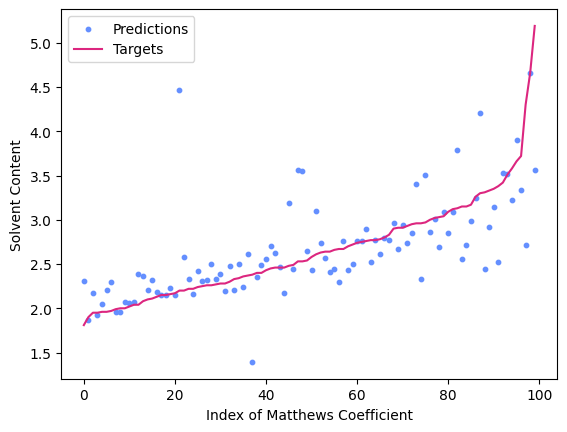

In [58]:
order = np.argsort(targets_testing.flatten())
xvals = np.arange(len(targets_testing))
plt.scatter(xvals,predictions_test[order],label='Predictions',s=10,color=colors1[0])
plt.plot(xvals,targets_testing[order],label='Targets',color=colors1[2])
#plt.fill_between(xvals,targets_testing[order].flatten()-np.sqrt(var_performance),targets_testing[order].flatten()+np.sqrt(var_performance),alpha=0.5,color=colors1[2])
plt.xlabel('Index of Matthews Coefficient')
plt.ylabel('Solvent Content')
plt.legend()
plt.show()

### Problem 2: Learn Matthews Coefficient from geometry and mass of protein

In [18]:
all_inputs = np.zeros((len(data), 9))
all_targets = np.zeros((len(data), 1))
indices = []
for i in range(len(data)):
    entry = data[i]['entry']
    if 'cell' in entry and 'density_matthews' in entry['exptl_crystal'][0]:
        all_inputs[i, 0] = entry['cell']['angle_alpha']
        all_inputs[i, 1] = entry['cell']['angle_beta']
        all_inputs[i, 2] = entry['cell']['angle_gamma']
        all_inputs[i, 3] = entry['cell']['length_a']
        all_inputs[i, 4] = entry['cell']['length_b']
        all_inputs[i, 5] = entry['cell']['length_c']
        all_inputs[i, 6] = char_to_float(entry['symmetry']['space_group_name_hm'])
        all_inputs[i, 7] = float(entry['symmetry']['int_tables_number'])
        all_inputs[i, 8] = len(entry['pdbx_seq_one_letter_code'])*110    # protein mass estimation
        all_targets[i] = entry['exptl_crystal'][0]['density_matthews']
        indices.append(i)
    # else:
    #     print('skipped %d' % i)
all_inputs = all_inputs[indices]
all_targets = all_targets[indices]

print('Number of entries: %d' % len(all_inputs))

Number of entries: 5075


In [46]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.random.permutation(len(all_inputs))

# Split the indices for training, testing, and validation sets
train_indices = indices[:50 * len(all_inputs) // 51]
test_indices = indices[50 * len(all_inputs) // 51:]

# Create the training, testing, and validation sets
inputs_training = all_inputs[train_indices]
targets_training = all_targets[train_indices]
inputs_testing = all_inputs[test_indices]
targets_testing = all_targets[test_indices]

In [47]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
inputs_training = scaler.fit_transform(inputs_training)
inputs_testing = scaler.transform(inputs_testing)

In [48]:
input_tensor = torch.tensor(inputs_training, dtype=torch.float32)
target_tensor = torch.tensor(targets_training, dtype=torch.float32)

## Define Model

In [49]:
# Define the model architecture using a sequential container

# define input size, hidden layer size, output size 
D_i, D_k, D_o = 9, 100, 1

# The model consists of:
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    # nn.ReLU(),
    # nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o),
)

In [50]:
# Define the loss function and optimizer
# Mean Squared Error (MSE) is used as the loss function
criterion = nn.MSELoss()

In [51]:
# Adam optimizer is used with weight decay (L2 regularization) to prevent overfitting
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
# object that decreases learning rate by half every N epochs 
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

In [52]:

# Train the model
num_epochs = 1000  # Number of epochs to train the model
losses = []  # List to store the loss value for each epoch
# load data
data_loader = DataLoader(TensorDataset(input_tensor,target_tensor), batch_size=64)
# Iterate over the epochs
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss value for this epoch
    # Iterate over the training data in batches
    for i, dataset in enumerate(data_loader):
        # Get the inputs and targets from the data loader
        inputs, targets = dataset
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()  
        
        # Forward pass: compute the model output
        outputs = model(inputs)
        # Compute the loss between the model output and the actual targets
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()        # Compute the gradient of the loss with respect to model parameters
        optimizer.step()       # Update the model parameters based on the computed gradients
        
        # Store the loss value for this epoch
        epoch_loss += loss.item()
    losses.append(epoch_loss)  # Store the loss value for this epoch
    print(f'Epoch {epoch:5d}, loss {epoch_loss:.3f}')
    # tell scheduler to consider updating learning rate 
    scheduler.step()

Epoch     0, loss 152.902
Epoch     1, loss 39.321
Epoch     2, loss 26.650
Epoch     3, loss 22.714
Epoch     4, loss 20.758
Epoch     5, loss 19.657
Epoch     6, loss 18.987
Epoch     7, loss 18.545
Epoch     8, loss 18.222
Epoch     9, loss 17.957
Epoch    10, loss 17.752
Epoch    11, loss 17.577
Epoch    12, loss 17.431
Epoch    13, loss 17.288
Epoch    14, loss 17.166
Epoch    15, loss 17.051
Epoch    16, loss 16.946
Epoch    17, loss 16.842
Epoch    18, loss 16.752
Epoch    19, loss 16.664
Epoch    20, loss 16.556
Epoch    21, loss 16.453
Epoch    22, loss 16.358
Epoch    23, loss 16.256
Epoch    24, loss 16.165
Epoch    25, loss 16.082
Epoch    26, loss 15.989
Epoch    27, loss 15.905
Epoch    28, loss 15.799
Epoch    29, loss 15.705
Epoch    30, loss 15.609
Epoch    31, loss 15.524
Epoch    32, loss 15.424
Epoch    33, loss 15.341
Epoch    34, loss 15.262
Epoch    35, loss 15.176
Epoch    36, loss 15.101
Epoch    37, loss 15.005
Epoch    38, loss 14.939
Epoch    39, loss 14.882

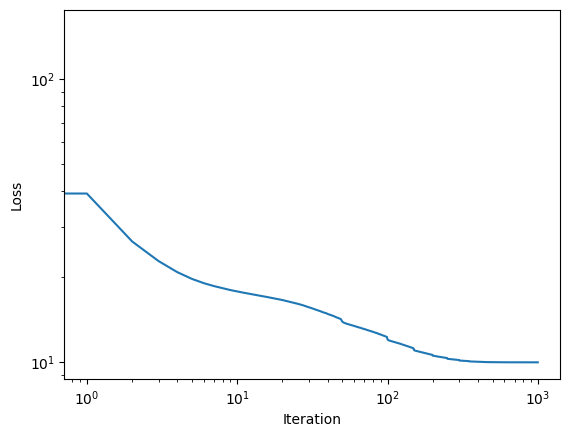

In [53]:
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [54]:
predictions_test = model(torch.tensor(inputs_testing, dtype=torch.float32)).detach().numpy()

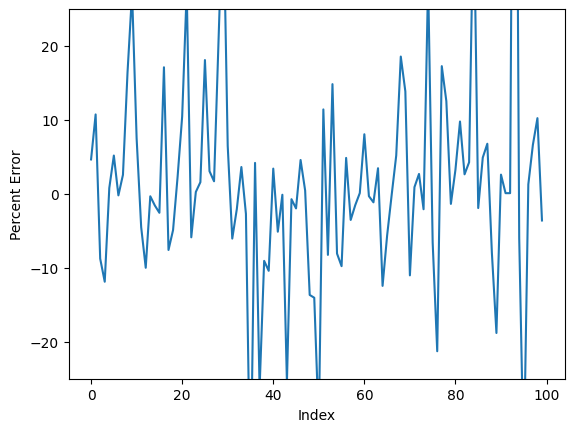

In [55]:
plt.plot(100*(predictions_test/targets_testing-1))
plt.xlabel('Index')
plt.ylabel('Percent Error')
plt.ylim([-25,25])
plt.show()

In [56]:
var_performance = np.sum((predictions_test - targets_testing)**2)/len(predictions_test)
print('Variance of performance: %.3f' % var_performance)

Variance of performance: 0.211


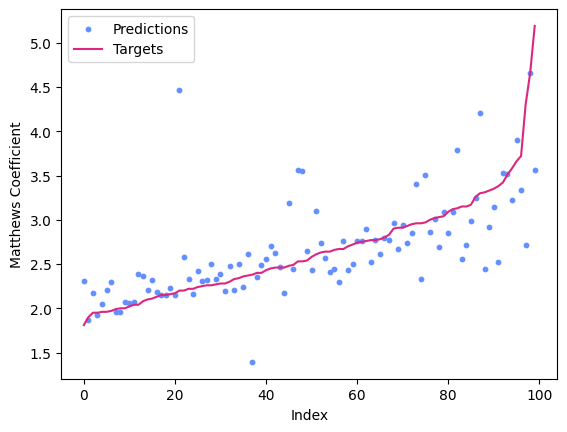

In [57]:
order = np.argsort(targets_testing.flatten())
xvals = np.arange(len(targets_testing))
plt.scatter(xvals,predictions_test[order],label='Predictions',s=10,color=colors1[0])
plt.plot(xvals,targets_testing[order],label='Targets',color=colors1[2])
#plt.fill_between(xvals,targets_testing[order].flatten()-np.sqrt(var_performance),targets_testing[order].flatten()+np.sqrt(var_performance),alpha=0.5,color=colors1[2])
plt.xlabel('Index')
plt.ylabel('Matthews Coefficient')
plt.legend()
plt.show()